# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir,transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,num_workers=6)
    
    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 16
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

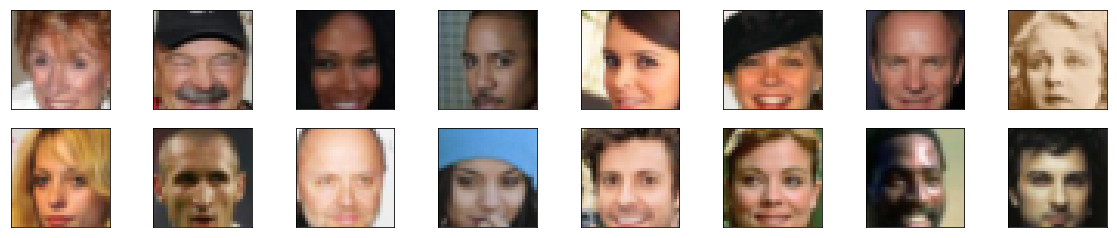

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9373)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        self.conv_dim = conv_dim
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) 
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out))
        out = self.dropout(out)
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Linear') != -1 or classname.find('Conv2d') != -1:
        m.weight.data.normal_(0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim
lr = 0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.3260 | g_loss: 0.7092
Epoch [    1/   20] | d_loss: 0.8420 | g_loss: 1.4846
Epoch [    1/   20] | d_loss: 0.4072 | g_loss: 2.6906
Epoch [    1/   20] | d_loss: 0.3496 | g_loss: 2.7458
Epoch [    1/   20] | d_loss: 0.4425 | g_loss: 3.4586
Epoch [    1/   20] | d_loss: 0.3086 | g_loss: 3.5070
Epoch [    1/   20] | d_loss: 0.2508 | g_loss: 3.2726
Epoch [    1/   20] | d_loss: 0.3108 | g_loss: 3.0761
Epoch [    1/   20] | d_loss: 0.4842 | g_loss: 2.5450
Epoch [    1/   20] | d_loss: 0.5915 | g_loss: 2.3699
Epoch [    1/   20] | d_loss: 0.5286 | g_loss: 2.9347
Epoch [    1/   20] | d_loss: 0.5046 | g_loss: 3.6086
Epoch [    1/   20] | d_loss: 0.8125 | g_loss: 1.6049
Epoch [    1/   20] | d_loss: 1.0270 | g_loss: 2.6721
Epoch [    1/   20] | d_loss: 0.4472 | g_loss: 1.7514
Epoch [    1/   20] | d_loss: 0.6940 | g_loss: 1.6993
Epoch [    1/   20] | d_loss: 0.6312 | g_loss: 2.1381
Epoch [    1/   20] | d_loss: 0.8392 | g_loss: 2.0855
Epoch [    1/   20] | d_loss

Epoch [    2/   20] | d_loss: 0.9960 | g_loss: 1.7198
Epoch [    2/   20] | d_loss: 1.6709 | g_loss: 1.3735
Epoch [    2/   20] | d_loss: 0.9611 | g_loss: 1.2407
Epoch [    2/   20] | d_loss: 1.3988 | g_loss: 0.8115
Epoch [    2/   20] | d_loss: 1.1949 | g_loss: 0.5067
Epoch [    2/   20] | d_loss: 1.1257 | g_loss: 1.0346
Epoch [    2/   20] | d_loss: 0.9808 | g_loss: 1.1557
Epoch [    2/   20] | d_loss: 0.8565 | g_loss: 0.9354
Epoch [    2/   20] | d_loss: 0.9589 | g_loss: 1.4313
Epoch [    2/   20] | d_loss: 1.1584 | g_loss: 0.9189
Epoch [    2/   20] | d_loss: 0.8353 | g_loss: 1.5889
Epoch [    2/   20] | d_loss: 1.4994 | g_loss: 0.9266
Epoch [    2/   20] | d_loss: 1.3994 | g_loss: 1.4435
Epoch [    2/   20] | d_loss: 0.8800 | g_loss: 1.3630
Epoch [    2/   20] | d_loss: 1.5139 | g_loss: 1.1885
Epoch [    2/   20] | d_loss: 1.1884 | g_loss: 0.9498
Epoch [    2/   20] | d_loss: 0.8349 | g_loss: 1.4647
Epoch [    2/   20] | d_loss: 0.8749 | g_loss: 1.4885
Epoch [    2/   20] | d_loss

Epoch [    3/   20] | d_loss: 1.1910 | g_loss: 1.2911
Epoch [    3/   20] | d_loss: 0.8742 | g_loss: 1.1571
Epoch [    3/   20] | d_loss: 1.0917 | g_loss: 1.3993
Epoch [    3/   20] | d_loss: 1.3091 | g_loss: 1.4392
Epoch [    3/   20] | d_loss: 0.7353 | g_loss: 0.9080
Epoch [    3/   20] | d_loss: 0.7899 | g_loss: 1.6897
Epoch [    3/   20] | d_loss: 1.2561 | g_loss: 1.1263
Epoch [    3/   20] | d_loss: 1.2791 | g_loss: 0.9678
Epoch [    3/   20] | d_loss: 0.9620 | g_loss: 0.9966
Epoch [    3/   20] | d_loss: 1.0511 | g_loss: 1.0096
Epoch [    3/   20] | d_loss: 1.1472 | g_loss: 1.5795
Epoch [    3/   20] | d_loss: 1.2179 | g_loss: 1.0144
Epoch [    3/   20] | d_loss: 1.0165 | g_loss: 1.7630
Epoch [    3/   20] | d_loss: 0.9507 | g_loss: 1.5486
Epoch [    3/   20] | d_loss: 1.4339 | g_loss: 1.3143
Epoch [    3/   20] | d_loss: 1.2638 | g_loss: 0.7837
Epoch [    3/   20] | d_loss: 1.1512 | g_loss: 1.1560
Epoch [    3/   20] | d_loss: 1.2986 | g_loss: 1.5258
Epoch [    3/   20] | d_loss

Epoch [    5/   20] | d_loss: 1.3084 | g_loss: 1.1937
Epoch [    5/   20] | d_loss: 1.0632 | g_loss: 1.7317
Epoch [    5/   20] | d_loss: 0.9905 | g_loss: 1.4017
Epoch [    5/   20] | d_loss: 1.8170 | g_loss: 1.1845
Epoch [    5/   20] | d_loss: 0.6387 | g_loss: 1.8678
Epoch [    5/   20] | d_loss: 0.8319 | g_loss: 1.1285
Epoch [    5/   20] | d_loss: 0.7577 | g_loss: 1.3672
Epoch [    5/   20] | d_loss: 0.9701 | g_loss: 1.1709
Epoch [    5/   20] | d_loss: 1.0291 | g_loss: 1.5213
Epoch [    5/   20] | d_loss: 0.9344 | g_loss: 1.1111
Epoch [    5/   20] | d_loss: 0.9914 | g_loss: 1.5381
Epoch [    5/   20] | d_loss: 0.9883 | g_loss: 2.3091
Epoch [    5/   20] | d_loss: 1.4140 | g_loss: 1.5115
Epoch [    5/   20] | d_loss: 0.8488 | g_loss: 1.1868
Epoch [    5/   20] | d_loss: 0.7719 | g_loss: 1.4966
Epoch [    5/   20] | d_loss: 0.7561 | g_loss: 1.6922
Epoch [    5/   20] | d_loss: 1.8594 | g_loss: 1.8417
Epoch [    5/   20] | d_loss: 0.9731 | g_loss: 1.0319
Epoch [    5/   20] | d_loss

Epoch [    6/   20] | d_loss: 0.7145 | g_loss: 0.9698
Epoch [    6/   20] | d_loss: 1.1208 | g_loss: 1.4985
Epoch [    6/   20] | d_loss: 1.6468 | g_loss: 0.9869
Epoch [    6/   20] | d_loss: 0.6498 | g_loss: 1.5363
Epoch [    6/   20] | d_loss: 0.7094 | g_loss: 1.0763
Epoch [    6/   20] | d_loss: 0.6652 | g_loss: 1.2682
Epoch [    6/   20] | d_loss: 0.5762 | g_loss: 1.3486
Epoch [    6/   20] | d_loss: 0.9773 | g_loss: 1.1836
Epoch [    6/   20] | d_loss: 1.4283 | g_loss: 0.7734
Epoch [    6/   20] | d_loss: 0.9165 | g_loss: 1.2895
Epoch [    6/   20] | d_loss: 0.8184 | g_loss: 1.8683
Epoch [    6/   20] | d_loss: 0.7182 | g_loss: 1.4924
Epoch [    6/   20] | d_loss: 0.6989 | g_loss: 1.1133
Epoch [    6/   20] | d_loss: 0.9035 | g_loss: 0.8504
Epoch [    6/   20] | d_loss: 0.8097 | g_loss: 1.3171
Epoch [    6/   20] | d_loss: 1.0620 | g_loss: 0.9557
Epoch [    6/   20] | d_loss: 0.7457 | g_loss: 1.3468
Epoch [    6/   20] | d_loss: 0.6239 | g_loss: 0.7603
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 1.1295 | g_loss: 1.5591
Epoch [    7/   20] | d_loss: 0.8758 | g_loss: 1.2028
Epoch [    7/   20] | d_loss: 1.0497 | g_loss: 1.9525
Epoch [    7/   20] | d_loss: 1.1837 | g_loss: 1.5662
Epoch [    7/   20] | d_loss: 0.6425 | g_loss: 1.8052
Epoch [    7/   20] | d_loss: 1.1787 | g_loss: 1.3383
Epoch [    7/   20] | d_loss: 0.8442 | g_loss: 0.9214
Epoch [    7/   20] | d_loss: 1.2775 | g_loss: 1.2481
Epoch [    7/   20] | d_loss: 0.8764 | g_loss: 1.6623
Epoch [    7/   20] | d_loss: 0.9359 | g_loss: 1.7908
Epoch [    7/   20] | d_loss: 1.4028 | g_loss: 0.9871
Epoch [    7/   20] | d_loss: 1.1727 | g_loss: 2.0732
Epoch [    7/   20] | d_loss: 1.5930 | g_loss: 1.1278
Epoch [    7/   20] | d_loss: 1.0813 | g_loss: 1.1033
Epoch [    7/   20] | d_loss: 1.0800 | g_loss: 1.3174
Epoch [    7/   20] | d_loss: 0.4888 | g_loss: 2.0328
Epoch [    7/   20] | d_loss: 1.5772 | g_loss: 1.2642
Epoch [    7/   20] | d_loss: 0.7445 | g_loss: 1.4183
Epoch [    7/   20] | d_loss

Epoch [    9/   20] | d_loss: 0.7169 | g_loss: 1.7832
Epoch [    9/   20] | d_loss: 1.0215 | g_loss: 1.8031
Epoch [    9/   20] | d_loss: 1.1199 | g_loss: 1.7283
Epoch [    9/   20] | d_loss: 0.9369 | g_loss: 2.4716
Epoch [    9/   20] | d_loss: 0.9480 | g_loss: 1.2294
Epoch [    9/   20] | d_loss: 0.9342 | g_loss: 1.8042
Epoch [    9/   20] | d_loss: 0.6885 | g_loss: 1.8962
Epoch [    9/   20] | d_loss: 1.7975 | g_loss: 1.0945
Epoch [    9/   20] | d_loss: 0.8502 | g_loss: 1.7351
Epoch [    9/   20] | d_loss: 0.8366 | g_loss: 1.4912
Epoch [    9/   20] | d_loss: 1.0640 | g_loss: 1.2732
Epoch [    9/   20] | d_loss: 1.3722 | g_loss: 1.7521
Epoch [    9/   20] | d_loss: 0.8050 | g_loss: 1.8106
Epoch [    9/   20] | d_loss: 0.7554 | g_loss: 1.0976
Epoch [    9/   20] | d_loss: 0.8245 | g_loss: 1.1342
Epoch [    9/   20] | d_loss: 1.1013 | g_loss: 0.9707
Epoch [    9/   20] | d_loss: 0.7049 | g_loss: 2.1118
Epoch [    9/   20] | d_loss: 1.1023 | g_loss: 1.9089
Epoch [    9/   20] | d_loss

Epoch [   10/   20] | d_loss: 0.6389 | g_loss: 1.8228
Epoch [   10/   20] | d_loss: 0.7197 | g_loss: 2.9648
Epoch [   10/   20] | d_loss: 0.7718 | g_loss: 1.6318
Epoch [   10/   20] | d_loss: 1.1590 | g_loss: 1.5724
Epoch [   10/   20] | d_loss: 1.0721 | g_loss: 2.0292
Epoch [   10/   20] | d_loss: 0.3749 | g_loss: 2.1688
Epoch [   10/   20] | d_loss: 0.4742 | g_loss: 1.7660
Epoch [   10/   20] | d_loss: 1.2785 | g_loss: 1.7339
Epoch [   10/   20] | d_loss: 1.1561 | g_loss: 1.3756
Epoch [   10/   20] | d_loss: 0.7060 | g_loss: 1.6442
Epoch [   10/   20] | d_loss: 0.7665 | g_loss: 1.5093
Epoch [   10/   20] | d_loss: 0.5017 | g_loss: 1.5423
Epoch [   10/   20] | d_loss: 0.6298 | g_loss: 1.9798
Epoch [   10/   20] | d_loss: 0.7191 | g_loss: 2.2887
Epoch [   10/   20] | d_loss: 0.8610 | g_loss: 0.8337
Epoch [   10/   20] | d_loss: 0.8627 | g_loss: 2.1534
Epoch [   10/   20] | d_loss: 0.8422 | g_loss: 0.9634
Epoch [   10/   20] | d_loss: 0.8230 | g_loss: 2.0657
Epoch [   10/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.8779 | g_loss: 1.7878
Epoch [   11/   20] | d_loss: 0.6650 | g_loss: 1.5790
Epoch [   11/   20] | d_loss: 0.4967 | g_loss: 1.9070
Epoch [   11/   20] | d_loss: 0.5924 | g_loss: 1.6013
Epoch [   11/   20] | d_loss: 0.5559 | g_loss: 1.8155
Epoch [   11/   20] | d_loss: 0.9410 | g_loss: 2.1532
Epoch [   11/   20] | d_loss: 0.7330 | g_loss: 2.1724
Epoch [   11/   20] | d_loss: 0.6402 | g_loss: 1.1949
Epoch [   11/   20] | d_loss: 0.7412 | g_loss: 1.4366
Epoch [   11/   20] | d_loss: 1.3571 | g_loss: 1.6279
Epoch [   11/   20] | d_loss: 1.0757 | g_loss: 1.1190
Epoch [   11/   20] | d_loss: 0.6799 | g_loss: 1.3411
Epoch [   11/   20] | d_loss: 0.6398 | g_loss: 1.1050
Epoch [   11/   20] | d_loss: 0.7397 | g_loss: 2.2389
Epoch [   11/   20] | d_loss: 1.2644 | g_loss: 1.6894
Epoch [   11/   20] | d_loss: 0.9768 | g_loss: 1.1265
Epoch [   11/   20] | d_loss: 0.7196 | g_loss: 2.0739
Epoch [   11/   20] | d_loss: 1.1591 | g_loss: 1.3208
Epoch [   11/   20] | d_loss

Epoch [   13/   20] | d_loss: 1.4786 | g_loss: 2.0872
Epoch [   13/   20] | d_loss: 1.1022 | g_loss: 3.0083
Epoch [   13/   20] | d_loss: 0.9251 | g_loss: 1.8758
Epoch [   13/   20] | d_loss: 1.5567 | g_loss: 1.8545
Epoch [   13/   20] | d_loss: 1.3972 | g_loss: 2.4332
Epoch [   13/   20] | d_loss: 0.8872 | g_loss: 2.1677
Epoch [   13/   20] | d_loss: 0.5910 | g_loss: 2.4453
Epoch [   13/   20] | d_loss: 0.3898 | g_loss: 1.1737
Epoch [   13/   20] | d_loss: 1.0864 | g_loss: 2.2201
Epoch [   13/   20] | d_loss: 0.7927 | g_loss: 1.8430
Epoch [   13/   20] | d_loss: 0.9478 | g_loss: 1.5090
Epoch [   13/   20] | d_loss: 0.9335 | g_loss: 2.1659
Epoch [   13/   20] | d_loss: 0.5820 | g_loss: 1.4760
Epoch [   13/   20] | d_loss: 0.4009 | g_loss: 2.4123
Epoch [   13/   20] | d_loss: 0.8107 | g_loss: 1.5912
Epoch [   13/   20] | d_loss: 0.8455 | g_loss: 2.1884
Epoch [   13/   20] | d_loss: 0.2118 | g_loss: 1.8322
Epoch [   13/   20] | d_loss: 0.3199 | g_loss: 1.5736
Epoch [   13/   20] | d_loss

Epoch [   14/   20] | d_loss: 0.7193 | g_loss: 2.0189
Epoch [   14/   20] | d_loss: 0.4874 | g_loss: 2.7574
Epoch [   14/   20] | d_loss: 0.9416 | g_loss: 1.9910
Epoch [   14/   20] | d_loss: 0.7439 | g_loss: 1.0285
Epoch [   14/   20] | d_loss: 1.2186 | g_loss: 2.1501
Epoch [   14/   20] | d_loss: 1.0131 | g_loss: 1.1453
Epoch [   14/   20] | d_loss: 0.9563 | g_loss: 2.8923
Epoch [   14/   20] | d_loss: 1.3473 | g_loss: 1.8525
Epoch [   14/   20] | d_loss: 1.1619 | g_loss: 1.2178
Epoch [   14/   20] | d_loss: 0.5144 | g_loss: 1.6082
Epoch [   14/   20] | d_loss: 1.1294 | g_loss: 1.8450
Epoch [   14/   20] | d_loss: 0.5876 | g_loss: 2.0590
Epoch [   14/   20] | d_loss: 0.7215 | g_loss: 1.6114
Epoch [   14/   20] | d_loss: 0.4867 | g_loss: 1.5838
Epoch [   14/   20] | d_loss: 0.7469 | g_loss: 1.8107
Epoch [   14/   20] | d_loss: 0.4203 | g_loss: 0.5411
Epoch [   14/   20] | d_loss: 0.7700 | g_loss: 2.3354
Epoch [   14/   20] | d_loss: 0.9423 | g_loss: 1.8683
Epoch [   14/   20] | d_loss

Epoch [   15/   20] | d_loss: 0.4684 | g_loss: 1.6724
Epoch [   15/   20] | d_loss: 0.7513 | g_loss: 1.4592
Epoch [   15/   20] | d_loss: 1.0722 | g_loss: 1.6943
Epoch [   15/   20] | d_loss: 0.8680 | g_loss: 0.6636
Epoch [   15/   20] | d_loss: 0.9400 | g_loss: 1.6804
Epoch [   15/   20] | d_loss: 0.8516 | g_loss: 1.5031
Epoch [   15/   20] | d_loss: 1.0429 | g_loss: 1.4864
Epoch [   15/   20] | d_loss: 0.4523 | g_loss: 1.3237
Epoch [   15/   20] | d_loss: 0.9389 | g_loss: 3.4511
Epoch [   15/   20] | d_loss: 0.9283 | g_loss: 2.1453
Epoch [   15/   20] | d_loss: 0.8021 | g_loss: 2.1196
Epoch [   15/   20] | d_loss: 1.0706 | g_loss: 2.1249
Epoch [   15/   20] | d_loss: 0.5584 | g_loss: 1.4637
Epoch [   15/   20] | d_loss: 1.2970 | g_loss: 2.2424
Epoch [   15/   20] | d_loss: 0.6639 | g_loss: 2.6494
Epoch [   15/   20] | d_loss: 0.2839 | g_loss: 1.8140
Epoch [   15/   20] | d_loss: 0.5461 | g_loss: 2.9636
Epoch [   15/   20] | d_loss: 0.7224 | g_loss: 2.4926
Epoch [   15/   20] | d_loss

Epoch [   17/   20] | d_loss: 0.3439 | g_loss: 1.5588
Epoch [   17/   20] | d_loss: 0.7310 | g_loss: 1.0863
Epoch [   17/   20] | d_loss: 0.8875 | g_loss: 1.9195
Epoch [   17/   20] | d_loss: 0.4031 | g_loss: 1.6353
Epoch [   17/   20] | d_loss: 1.0540 | g_loss: 2.6924
Epoch [   17/   20] | d_loss: 0.7520 | g_loss: 1.6974
Epoch [   17/   20] | d_loss: 0.9649 | g_loss: 1.4742
Epoch [   17/   20] | d_loss: 0.7266 | g_loss: 0.9727
Epoch [   17/   20] | d_loss: 0.9931 | g_loss: 2.3213
Epoch [   17/   20] | d_loss: 0.8598 | g_loss: 1.1027
Epoch [   17/   20] | d_loss: 0.9692 | g_loss: 2.6135
Epoch [   17/   20] | d_loss: 1.0081 | g_loss: 0.9447
Epoch [   17/   20] | d_loss: 0.5546 | g_loss: 2.6651
Epoch [   17/   20] | d_loss: 1.1533 | g_loss: 1.7378
Epoch [   17/   20] | d_loss: 0.8108 | g_loss: 1.2063
Epoch [   17/   20] | d_loss: 0.3406 | g_loss: 2.0015
Epoch [   17/   20] | d_loss: 0.4615 | g_loss: 1.8297
Epoch [   17/   20] | d_loss: 1.3390 | g_loss: 1.3289
Epoch [   17/   20] | d_loss

Epoch [   18/   20] | d_loss: 0.7963 | g_loss: 0.9485
Epoch [   18/   20] | d_loss: 0.7150 | g_loss: 2.0733
Epoch [   18/   20] | d_loss: 0.7546 | g_loss: 1.7572
Epoch [   18/   20] | d_loss: 0.3364 | g_loss: 2.7924
Epoch [   18/   20] | d_loss: 0.4865 | g_loss: 2.6298
Epoch [   18/   20] | d_loss: 0.3291 | g_loss: 3.3532
Epoch [   18/   20] | d_loss: 1.3503 | g_loss: 1.8659
Epoch [   18/   20] | d_loss: 0.2497 | g_loss: 2.4760
Epoch [   18/   20] | d_loss: 0.3815 | g_loss: 4.0941
Epoch [   18/   20] | d_loss: 0.2759 | g_loss: 1.6955
Epoch [   18/   20] | d_loss: 0.5485 | g_loss: 1.7492
Epoch [   18/   20] | d_loss: 0.3886 | g_loss: 2.2862
Epoch [   18/   20] | d_loss: 0.2348 | g_loss: 2.2304
Epoch [   18/   20] | d_loss: 0.5893 | g_loss: 2.5972
Epoch [   18/   20] | d_loss: 0.8205 | g_loss: 1.8024
Epoch [   18/   20] | d_loss: 0.9824 | g_loss: 2.1720
Epoch [   18/   20] | d_loss: 0.8174 | g_loss: 1.1066
Epoch [   18/   20] | d_loss: 0.3779 | g_loss: 3.9056
Epoch [   18/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.8411 | g_loss: 3.2427
Epoch [   19/   20] | d_loss: 0.7544 | g_loss: 0.9403
Epoch [   19/   20] | d_loss: 1.1843 | g_loss: 1.3407
Epoch [   19/   20] | d_loss: 0.7746 | g_loss: 2.7310
Epoch [   19/   20] | d_loss: 0.2287 | g_loss: 0.9935
Epoch [   19/   20] | d_loss: 0.4751 | g_loss: 1.5090
Epoch [   19/   20] | d_loss: 0.4946 | g_loss: 2.5802
Epoch [   19/   20] | d_loss: 1.3141 | g_loss: 2.4270
Epoch [   19/   20] | d_loss: 1.5467 | g_loss: 2.5862
Epoch [   19/   20] | d_loss: 0.9857 | g_loss: 2.9313
Epoch [   19/   20] | d_loss: 1.2901 | g_loss: 1.9601
Epoch [   19/   20] | d_loss: 1.0118 | g_loss: 1.9465
Epoch [   19/   20] | d_loss: 1.0339 | g_loss: 2.5490
Epoch [   19/   20] | d_loss: 0.9465 | g_loss: 1.8580
Epoch [   19/   20] | d_loss: 1.0736 | g_loss: 1.9651
Epoch [   19/   20] | d_loss: 0.8946 | g_loss: 2.6930
Epoch [   19/   20] | d_loss: 1.1093 | g_loss: 1.2196
Epoch [   19/   20] | d_loss: 0.6714 | g_loss: 0.8991
Epoch [   19/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

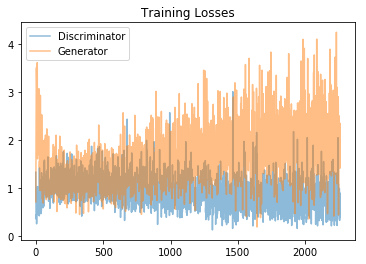

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

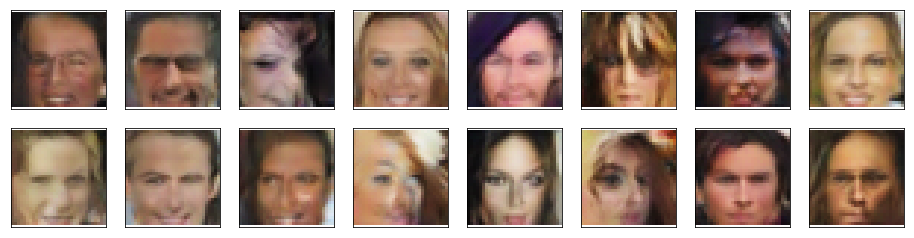

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
The images have low resolution this can be improved by using high-resolution data 
The model was traied for 20 Epoch more traing can impove the results 
I have used a simple network buliding a deep network can impove the results.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.